# 다른 방식으로 훈련 진행

In [1]:
# 기본 작업 경로 설정

import os
notebook_path = os.path.abspath("project_3_git/readme.md")
notebook_dir = os.path.dirname(notebook_path)
os.chdir(notebook_dir)

# 현재 작업 디렉토리 출력
print("Current working directory: ", os.getcwd())

Current working directory:  /mnt/e/py_data/project_3_git


In [2]:
# json 파일 가져오기
import json
from sklearn.model_selection import train_test_split

# JSON 파일에서 딕셔너리 읽기
with open('data/text_data/output_text.json', 'r') as file:
    data_loaded = json.load(file)

In [3]:
all_of_data_sets = []
for i in data_loaded.values():
    all_of_data_sets.append(f'입력값 : {i[0]} \n출력값 : {i[1]}')

In [4]:
train_data, test_data = train_test_split(all_of_data_sets, train_size=5000, random_state=42)

In [5]:
len(train_data), len(test_data)

(5000, 994)

In [15]:
from transformers import GPT2LMHeadModel, Trainer, EarlyStoppingCallback, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset
from transformers import PreTrainedTokenizerFast



# 모델 로드('skt/kogpt2-base-v2')
model_name = "skt/kogpt2-base-v2"
model = GPT2LMHeadModel.from_pretrained(model_name)

# 토크나이저 로드

tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [16]:
name_of_f = 'kogpt2_2'
server_port = '6008'
batch_size = 16
train_epochs = 100

In [17]:
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=128)

In [18]:
tokenizer.pad_token = tokenizer.eos_token # 끝 토큰을 그냥 패드토큰으로 지정

# 문자열 리스트를 사전으로 변환 후 데이터셋 생성
train_dataset = Dataset.from_dict({"text": train_data})
test_dataset = Dataset.from_dict({"text": test_data})

# `text` 열의 데이터가 문자열 리스트 형태인지 확인합니다
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Data collator 준비
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Step 5: TrainingArguments 설정
training_args = TrainingArguments(
    output_dir=f'models/gpt2/{name_of_f}/',
    overwrite_output_dir=True,
    num_train_epochs=100,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    save_steps=100,
    save_total_limit=5,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True,
    report_to='tensorboard',  # TensorBoard로 로깅
    logging_dir=f'models/gpt2/{name_of_f}/logs',  # 로그 파일이 저장될 디렉토리
    logging_steps=10,  # 로깅 간격
    remove_unused_columns=False ,

    # 추가 인자
    learning_rate=5e-5,                     # 기본값에서 시작
    lr_scheduler_type="linear",             # 스케줄러
    warmup_steps=500,                       # 500 스텝 동안 학습률을 점진적으로 증가
    weight_decay=0.01,                      # l2 정규화 기법 중 하나
    max_grad_norm=1.0,                      # 그라디언트 클리핑
)

# Step 6: Trainer 설정 및 학습 시작
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,  # 평가 데이터셋 추가
    callbacks = [EarlyStoppingCallback(early_stopping_patience=10)]
)

trainer.train()

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 994/994 [00:00<00:00, 13877.88 examples/s]
/home/tommy/miniconda3/envs/p3/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.054000,1.031635
2,0.907700,0.964302
3,0.866500,0.937726
4,0.786500,0.925404
5,0.664800,0.948466
6,0.648100,0.963301
7,0.592300,0.998164
8,0.584100,0.999594
9,0.542300,1.015275
10,0.506200,1.058504


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=7000, training_loss=0.6638463218552726, metrics={'train_runtime': 1891.1101, 'train_samples_per_second': 264.395, 'train_steps_per_second': 26.439, 'total_flos': 4572610560000000.0, 'train_loss': 0.6638463218552726, 'epoch': 14.0})

In [19]:
# Step 6: 모델 저장
model.save_pretrained(f'models/gpt2/{name_of_f}/models')
tokenizer.save_pretrained(f'models/gpt2/{name_of_f}/models/tokenizer')

('models/gpt2/kogpt2_2/models/tokenizer/tokenizer_config.json',
 'models/gpt2/kogpt2_2/models/tokenizer/special_tokens_map.json',
 'models/gpt2/kogpt2_2/models/tokenizer/tokenizer.json')

In [ ]:
text_intput_text = '슬픔, 분노'

In [63]:
import torch

model = GPT2LMHeadModel.from_pretrained('models/gpt2/kogpt2_1/model')
# tokenizer = GPT2Tokenizer.from_pretrained('models/gpt2/kogpt2_1/model/tokenizer')

# 테스트 입력
test_input = test_x[1]
# 입력 토큰화
input_ids = tokenizer.encode(test_input, return_tensors='pt')

# 모델 예측
with torch.no_grad():
    outputs = model.generate(input_ids, max_length=50, num_beams=4, early_stopping=True)

# 예측 결과 디코딩
predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"테스트 입력: {test_input}")
print(f"모델의 예측: {predicted_text}")


테스트 입력: 기쁨, 재킷
모델의 예측: 기쁨, 재킷시네네네네네네네네네네네네네네네네네네


In [40]:
device = torch.device("cuda")

In [108]:
test_input = '기쁨, 슬픔'

In [109]:
# 평가 모드로 변경

model.eval()
model.to(device)

def generate_text(prompt, model, tokenizer, max_length=50, num_return_sequences=5):
    # 입력 텍스트를 토큰화
    inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # 생성 인자를 설정하여 모델이 텍스트를 생성
    outputs = model.generate(
        inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=1.9,
        do_sample=True,
        early_stopping=True
    ).to(device)

    # 생성된 텍스트를 디코딩
    generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    
    return generated_texts

generated_texts = generate_text('입력값:'+test_input+'\n출력값:', model, tokenizer)
    
for i, text in enumerate(generated_texts):
    print(f"Generated Text {i+1}:")
    print(text)
    print()

/home/tommy/miniconda3/envs/p3/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Generated Text 1:
입력값:기쁨, 슬픔
출력값:!? 무슨인지 궁금 모습이 어떤 일이네? 건 걸데, 정말 잘 일이 멋진! 정말 멋? 스타 것!가네 무슨 잘 멋진다이 모습이

Generated Text 2:
입력값:기쁨, 슬픔
출력값:나해?해 힘든가 멋진? 액 액니! 색 어떤데,경도니 조 안지시 안린지 차네경이요 안 오토신지시 멋진요.

Generated Text 3:
입력값:기쁨, 슬픔
출력값:가 힘 모습이 일이 매력 어떤나 독특?! 어떤네네 멋진데,네 모습이하가 무슨 건!!세데, 건네뭘!경이일리인지

Generated Text 4:
입력값:기쁨, 슬픔
출력값: 잘 걸 계신신지네 정말 독특 궁금신 멋진 멋 궁금셨! 정말 편의네 재 점에서 일이 흥미다일이요.요!!요

Generated Text 5:
입력값:기쁨, 슬픔
출력값: 건 힘든 일이요 데, 있었던가 일이일리 멋진 멋진 건 무슨네 일이 모습이요세 일을 모습이 일이네 모습이! 작업이 걸지 액 일을 액요



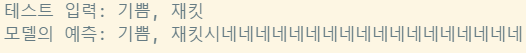